In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip drive/MyDrive/KSA_AI/DeepLearning/bee_wasp.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: kaggle_bee_vs_wasp/other_noinsect/576513.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/576622.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/576810.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/576855.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/576993.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577087.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577126.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577128.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577283.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577310.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577643.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577807.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/577847.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/578261.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/578295.jpg  
  inflating: kaggle_bee_vs_wasp/other_noinsect/578441.jpg  
  in

## Preprocessing

In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.spines as spines
import seaborn as sns
import pandas as pd

import tensorflow as tf

In [6]:
DATASET_PATH = "./kaggle_bee_vs_wasp"
label_csv = os.path.join(DATASET_PATH, 'labels.csv')
label_df = pd.read_csv(label_csv)
label_df.head(10)

label_df.set_index('id')
# print("Number of null values")
# print(label_df.isnull().sum())

label_df.is_validation.value_counts()
label_df.is_final_validation.value_counts()

0    9658
1    1763
Name: is_final_validation, dtype: int64

In [7]:
def set_train_type(row):
    if row['is_validation'] == 0 and row['is_final_validation'] == 0:
        return 'train'
    if row['is_validation'] ==1:
        return 'validation'
    else: return 'test'

 
label_df['type'] = label_df.apply(set_train_type, axis=1)
print('Number values of each type')
label_df['type'].value_counts()

print('train : val : test = 8 : 1 : 1')

Number values of each type
train : val : test = 8 : 1 : 1


## EDA

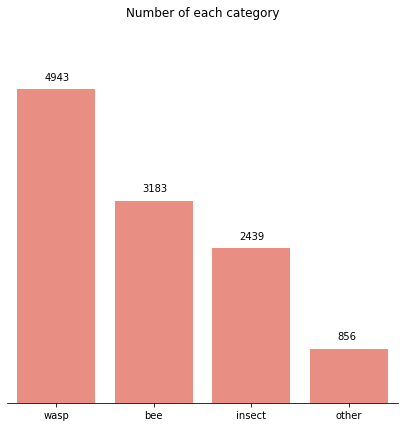

In [ ]:
insect_cat_counts = label_df["label"].value_counts()

plt.figure(figsize=(7,7))
g = sns.barplot(x=insect_cat_counts.index, y =insect_cat_counts, color='salmon')
g.set(title='Number of each category', ylim=[0,6000], yticks=[], ylabel='')
sns.despine(top=True, right=True, left=True, bottom=False)

for i in range(4):
    plt.text(x=i-0.12, y=insect_cat_counts[i] + 150, s=insect_cat_counts[i])
plt.show()

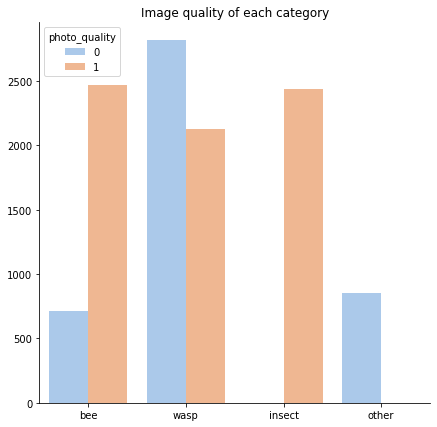

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11421 entries, 0 to 11420
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   11421 non-null  int64 
 1   path                 11421 non-null  object
 2   is_bee               11421 non-null  int64 
 3   is_wasp              11421 non-null  int64 
 4   is_otherinsect       11421 non-null  int64 
 5   is_other             11421 non-null  int64 
 6   photo_quality        11421 non-null  int64 
 7   is_validation        11421 non-null  int64 
 8   is_final_validation  11421 non-null  int64 
 9   label                11421 non-null  object
 10  type                 11421 non-null  object
dtypes: int64(8), object(3)
memory usage: 981.6+ KB


In [ ]:
plt.figure(figsize=(7,7))
g = sns.countplot(x='label', hue='photo_quality', data=label_df, palette="pastel")
g.set(xlabel='', ylabel='', title="Image quality of each category")
sns.despine()
plt.show()
label_df.label
label_df.info()

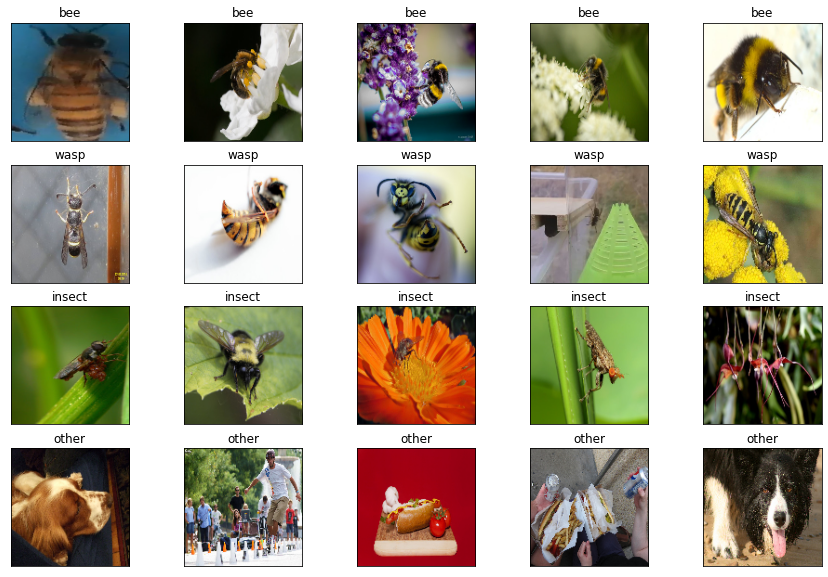

In [ ]:
def display_img(row, pos):
    fn = row['path'].replace('\\', os.sep)
    fn = os.path.join(DATASET_PATH, fn)
    #Read image from path
    img = cv2.imread(fn)
    #Resize all images with the same size
    img = cv2.resize(img, (128, 128))
    #Set RGB color for image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Display image, and set title
    plt.subplot(4, 5, pos)
    plt.imshow(img)
    plt.title(row['label'])
    #Remove ticks
    plt.xticks([])
    plt.yticks([])


bee = label_df[label_df["label"] == 'bee'].sample(5, random_state=42)
wasp = label_df[label_df["label"] == 'wasp'].sample(5, random_state=42)
insect = label_df[label_df["label"] == 'insect'].sample(5, random_state=42)
other = label_df[label_df["label"] == 'other'].sample(5, random_state=42)

plt.figure(figsize=(15,10))
pos = 1

for idx, row in bee.iterrows():
    display_img(row, pos)
    pos += 1

for idx, row in wasp.iterrows():
    display_img(row, pos)
    pos += 1

for idx, row in insect.iterrows():
    display_img(row, pos)
    pos += 1

for idx, row in other.iterrows():
    display_img(row, pos)
    pos += 1
    
plt.show()

## data split

In [8]:
category = ['bee', 'wasp', 'insect']
data = label_df[label_df['label'].isin(category)]
data['path'] = data['path'].str.replace('\\', os.sep)

np.random.seed(42)
# def split_train_test(data, test_ratio):
#     shuffled_indices = np.random.permutation(len(data))
#     test_set_size = int(len(data) * test_ratio)
#     test_indices = shuffled_indices[:test_set_size]
#     train_indices = shuffled_indices[test_set_size:]
#     return data.iloc[train_indices], data.iloc[test_indices]

## train : valid : test = 8 : 1 : 1
train = data[data['type'] == 'train']
validation = data[data['type'] == 'validation']
test = data[data['type'] == 'test']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses
import tensorflow.keras.callbacks as callbacks

tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
%load_ext tensorboard

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
TARGET_SIZE = (256, 256)
SEED = 42
BATCH_SIZE = 32
n_class = len(data['label'].unique())

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_datagen = train_datagen.flow_from_dataframe(train, 
                                                  directory=DATASET_PATH, 
                                                  x_col='path', 
                                                  y_col='label',
                                                  target_size=TARGET_SIZE,
                                                  seed=SEED
                                                  ) 

valid_datagen = test_datagen.flow_from_dataframe(validation,
                                                 directory=DATASET_PATH, 
                                                 x_col='path', 
                                                 y_col='label',
                                                 target_size=TARGET_SIZE,
                                                 seed=42
                                                 ) 

test_datagen = test_datagen.flow_from_dataframe(test, 
                                                directory=DATASET_PATH, 
                                                x_col='path', 
                                                y_col='label',
                                                target_size=TARGET_SIZE,
                                                seed=42
                                                ) 

Found 7341 validated image filenames belonging to 3 classes.
Found 1591 validated image filenames belonging to 3 classes.
Found 1633 validated image filenames belonging to 3 classes.


## Modeling

### residual block

In [ ]:
from tensorflow.keras.initializers import RandomNormal, Constant
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="elu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
                            keras.layers.Conv2D(filters, 3, strides=strides,
                                                padding="same", use_bias=False),
                            keras.layers.BatchNormalization(),
                            self.activation,
                            keras.layers.Conv2D(filters, 3, strides=1,
                                                padding="same", use_bias=False),
                            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                                keras.layers.Conv2D(filters, 1, strides=strides,
                                                    padding="same", use_bias=False),
                                keras.layers.BatchNormalization()
            ]

        def call(self, inputs):
            Z = inputs
            for layer in self.main_layers:
                Z = layer(Z)
            skip_Z = inputs
            for layer in self.skip_layers:
                skip_Z = layer(skip_Z)
            return self.activation(Z + skip_Z)

### model_1

In [ ]:
import datetime

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
model1 = keras.models.Sequential()
model1.add(keras.layers.Conv2D(64, 7, strides=2,
                              kernel_regularizer=keras.regularizers.L2(0.001),
                              input_shape=[256,256,3],
                              padding="same", use_bias=False))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.Activation("elu"))
model1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model1.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model1.add(keras.layers.GlobalAvgPool2D())
model1.add(keras.layers.Flatten())
model1.add(keras.layers.Dense(n_class, activation="softmax"))

In [ ]:
model1.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy']
              )

In [ ]:
model1.summary()

In [ ]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history1 = model1.fit(train_datagen,
                    validation_data=valid_datagen,
                    callbacks=[early_stopping, tensorboard_callback],
                    batch_size=32,
                    epochs=50)

In [ ]:
test_loss, test_acc = model1.evaluate(test_datagen, verbose=2)
print("Test accuracy:", test_acc)

28/28 - 2s - loss: 0.4202 - accuracy: 0.8125
Test accuracy: 0.8125


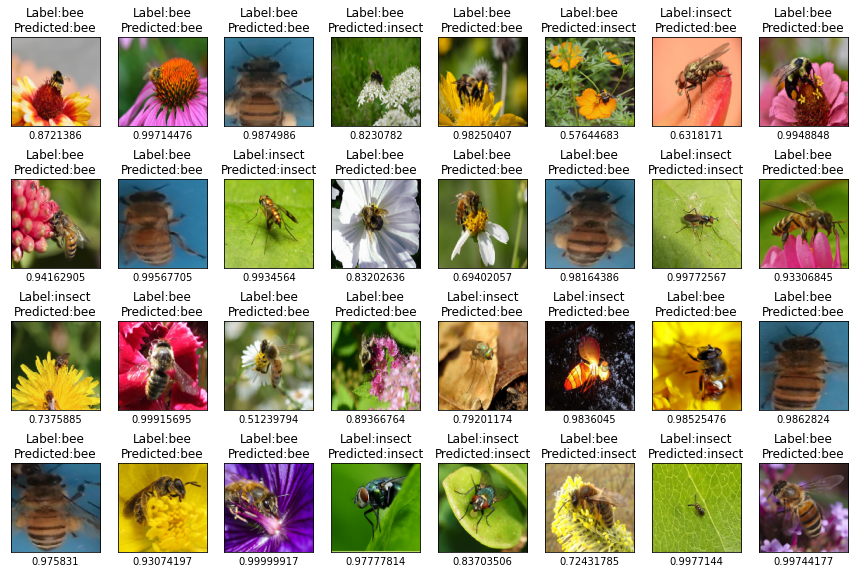

In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in test_datagen.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(test_datagen)
image = x[:, :, :, :]
true_index = np.argmax(y, axis=1)
plt.figure(figsize=(15,10))

for i in range(len(x)):
    image = x[i, :, :, :]
    plt.subplot(4, 8, i+1)
    image = cv2.resize(image, (128, 128))
    plt.imshow(image)

    prediction_scores = model1.predict(np.expand_dims(image, axis=0))
    predicted_index = np.argmax(prediction_scores)

    plt.title("Label:" + get_class_string_from_index(true_index[i])+"\n"+"Predicted:"+
              get_class_string_from_index(predicted_index))
    plt.xlabel(prediction_scores.reshape(-1,)[predicted_index])
    plt.xticks([])
    plt.yticks([])

### model_2

In [ ]:
import datetime

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
model2 = keras.models.Sequential()

# block 1
model2.add(keras.layers.Conv2D(64, 7,
                              kernel_regularizer=keras.regularizers.L2(0.001),
                              input_shape=[256,256,3],
                              padding="same", use_bias=False))
model2.add(keras.layers.Conv2D(64, 7,
                              kernel_regularizer=keras.regularizers.L2(0.001),
                              padding="same", use_bias=False))

model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Activation("elu"))
model2.add(keras.layers.MaxPooling2D(3))
model2.add(keras.layers.Dropout(0.3))

# block 2
model2.add(keras.layers.Conv2D(128, 3,
                              kernel_regularizer=keras.regularizers.L2(0.001),
                              padding="same", use_bias=False))
model2.add(keras.layers.Conv2D(128, 3,
                              kernel_regularizer=keras.regularizers.L2(0.001),
                              padding="same", use_bias=False))

model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Activation("elu"))
model2.add(keras.layers.MaxPooling2D(3))
model2.add(keras.layers.Dropout(0.3))

# block 3
model2.add(keras.layers.Conv2D(256, 3,
                              kernel_regularizer=keras.regularizers.L2(0.001),
                              padding="same", use_bias=False))
model2.add(keras.layers.Conv2D(256, 3,
                              kernel_regularizer=keras.regularizers.L2(0.001),
                              padding="same", use_bias=False))

model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Activation("elu"))
model2.add(keras.layers.MaxPooling2D(3))
model2.add(keras.layers.Dropout(0.3))

# block 4
model2.add(keras.layers.Conv2D(512, 3,
                              kernel_regularizer=keras.regularizers.L2(0.001),
                              padding="same", use_bias=False))
model2.add(keras.layers.Conv2D(512, 3,
                              kernel_regularizer=keras.regularizers.L2(0.001),
                              padding="same", use_bias=False))

model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Activation("elu"))
model2.add(keras.layers.MaxPooling2D(3))
model2.add(keras.layers.Dropout(0.3))

# block 5
model2.add(keras.layers.GlobalAvgPool2D())
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L2(0.001)))
model2.add(keras.layers.Dense(n_class, activation='softmax'))


In [ ]:
model2.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy']
              )

In [ ]:
model2.summary()

In [ ]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history2 = model2.fit(train_datagen,
                    validation_data=valid_datagen,
                    callbacks=[early_stopping, tensorboard_callback],
                    batch_size=32,
                    epochs=100)

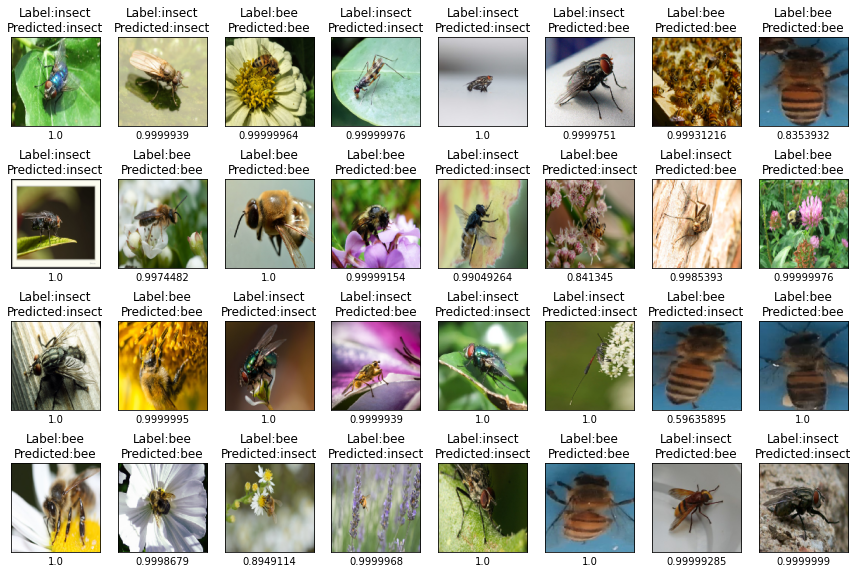

In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in test_datagen.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(test_datagen)
image = x[:, :, :, :]
true_index = np.argmax(y, axis=1)
plt.figure(figsize=(15,10))

for i in range(len(x)):
    image = x[i, :, :, :]
    plt.subplot(4, 8, i+1)
    image = cv2.resize(image, (128, 128))
    plt.imshow(image)

    prediction_scores = model2.predict(np.expand_dims(image, axis=0))
    predicted_index = np.argmax(prediction_scores)

    plt.title("Label:" + get_class_string_from_index(true_index[i])+"\n"+"Predicted:"+
              get_class_string_from_index(predicted_index))
    plt.xlabel(prediction_scores.reshape(-1,)[predicted_index])
    plt.xticks([])
    plt.yticks([])

In [ ]:
test_loss, test_acc = model2.evaluate(test_datagen, verbose=2)
print("Test accuracy:", test_acc)

### Model_DenseNet

In [13]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam

model = DenseNet121(weights=None, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3), classes=n_class)

opt = Adam(learning_rate=0.0005)

model.compile(loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy'])

In [ ]:
import tensorflow as tf
import datetime
import tensorflow.keras.callbacks as callbacks

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = callbacks.TensorBoard(logdir, histogram_freq=1)

early_stopping = callbacks.EarlyStopping(patience=7,
                                         monitor='val_loss',
                                         restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)



# checkpoint_path = "ckpt"
# model_checkpoint_callback = callbacks.ModelCheckpoint(
#     filepath=checkpoint_path,
#     save_weights_only=True,
#     monitor='val_loss',
#     save_best_only=True)

Data re-setting for Cross Validation

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 5, shuffle = True) 

X = pd.concat([train, validation], axis=0)
y = X['label']

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagenerator = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=45,
                                   zoom_range=0.3,
                                   shear_range=0.1,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagenerator = ImageDataGenerator(rescale=1./255.)

In [ ]:
BATCH_SIZE = 32
TARGET_SIZE = (320, 240)

cvscores = []
fold = 1
model_name=''
is_reduce_lr = False

for _ in range(3):
    if (_ == 2):
        is_reduce_lr = True
    for train_index, val_index in skf.split(X, y):
        train_data = X.iloc[train_index]
        val_data = X.iloc[val_index]
        print ('Fold: ',fold)
        
        
        train_datagen = train_datagenerator.flow_from_dataframe(train_data,
                                                          directory=DATASET_PATH, 
                                                          x_col='path', 
                                                          y_col='label',
                                                          class_mode="categorical",
                                                          target_size=TARGET_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          seed=42
                                                          ) 

        val_datagen = test_datagenerator.flow_from_dataframe(val_data,
                                                       directory=DATASET_PATH, 
                                                       x_col='path', 
                                                       y_col='label',
                                                       target_size=TARGET_SIZE,
                                                       class_mode="categorical",
                                                       batch_size=8,
                                                       seed=42
                                                       ) 

        if (os.path.isfile(model_name+'.h5')):
            model.load_weights(model_name)
        
        
        if is_reduce_lr:
            history = model.fit(train_datagen,
                                epochs=30,
                                callbacks=[early_stopping, reduce_lr, tensorboard_callback],
                                validation_data=val_datagen)
            
        else:
            history = model.fit(train_datagen,
                                epochs=30,
                                callbacks=[early_stopping, tensorboard_callback],
                                validation_data=val_datagen)
        
        
        
        # Save each fold model
        model_name = 'trained\\model_DenseNet3_fold_'+str(fold)+'.h5'
        model.save(model_name)
        
        # model.load_weights(model_name)
        # results = model.evaluate(validation_datagen)
        # results = dict(zip(model.metrics_names, results))
    	
        # cvscores.append(results['accuracy'])
        # cvscores.append(results['loss'])
    	
        tf.keras.backend.clear_session()
        
        # evaluate the model
        scores = model.evaluate(val_datagen, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        
        ## save the probability prediction of each fold in separate csv file
        # proba = model.predict(test_datagen, batch_size=None, steps=1)
        # labels=[np.argmax(pred) for pred in proba]
        # csv_name= 'submission_CNN_keras_aug_Fold'+str(fold)+'.csv'
        # create_submission(predictions=labels,path=csv_name)
        
        fold += 1


Fold:  1
Found 7145 validated image filenames belonging to 3 classes.
Found 1787 validated image filenames belonging to 3 classes.
Epoch 1/20
224/224 [==============================] - 141s 630ms/step - loss: 0.4618 - accuracy: 0.8213 - val_loss: 1.3157 - val_accuracy: 0.6077
Epoch 2/20
224/224 [==============================] - 140s 626ms/step - loss: 0.4434 - accuracy: 0.8325 - val_loss: 0.8553 - val_accuracy: 0.7107
Epoch 3/20
224/224 [==============================] - 141s 631ms/step - loss: 0.4222 - accuracy: 0.8376 - val_loss: 0.4883 - val_accuracy: 0.8198
Epoch 4/20
224/224 [==============================] - 142s 634ms/step - loss: 0.4031 - accuracy: 0.8444 - val_loss: 0.3877 - val_accuracy: 0.8562
Epoch 5/20
224/224 [==============================] - 140s 624ms/step - loss: 0.3936 - accuracy: 0.8473 - val_loss: 0.6330 - val_accuracy: 0.7778
Epoch 6/20
224/224 [==============================] - 141s 628ms/step - loss: 0.3863 - accuracy: 0.8515 - val_loss: 0.4520 - val_accuracy: 

KeyboardInterrupt: ignored

In [11]:
test_datagen = test_datagenerator.flow_from_dataframe(test,
                                                      directory=DATASET_PATH,
                                                      # only read images from `test` directory
                                                      # don't generate labels
                                                      class_mode=None,
                                                      x_col='path', 
                                                      # don't shuffle
                                                      shuffle=False,
                                                      # use same size as in training
                                                      target_size=TARGET_SIZE)

Found 1633 validated image filenames.


Text(0.5, 0, 'epoch')

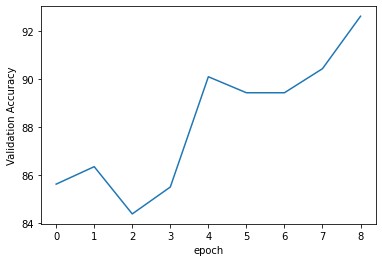

In [ ]:
#%% 학습이 길어져서 로컬에서 따로 학습 진행 필요.
plt.plot(cvscores)
plt.ylabel('Validation Accuracy')
plt.xlabel('epoch')

In [15]:
!cp drive/MyDrive/KSA_AI/DeepLearning/kaggle_bee_vs_wasp/model_DenseNet2_fold_15.h5 ./
model.load_weights('model_DenseNet2_fold_15.h5')

In [18]:
test_datagen = test_datagenerator.flow_from_dataframe(test,
                                                      directory=DATASET_PATH,
                                                      x_col='path',
                                                      y_col='label',
                                                      # don't shuffle
                                                      shuffle=True,
                                                      # use same size as in training
                                                      target_size=TARGET_SIZE)

test_loss, test_acc = model.evaluate(test_datagen, verbose=2)

Found 1633 validated image filenames belonging to 3 classes.


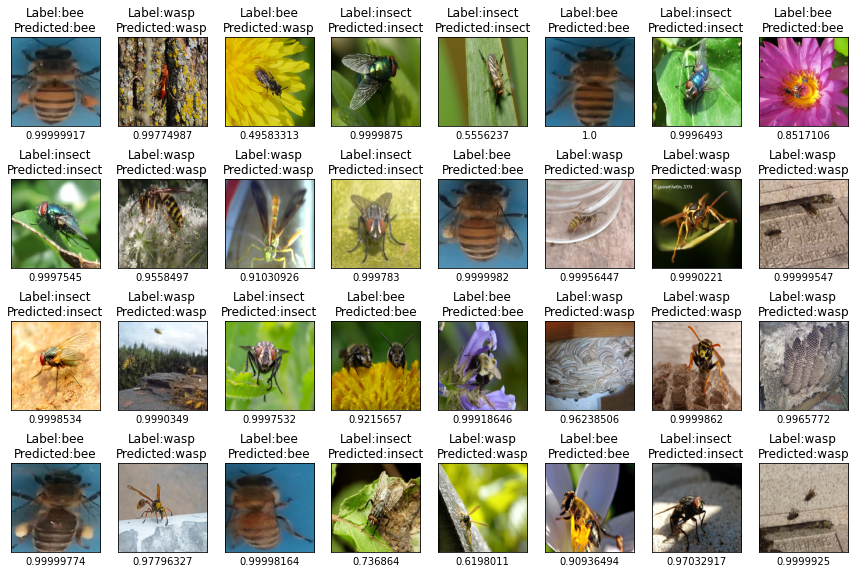

In [19]:
### Final Model Visualization
import cv2

def get_class_string_from_index(index):
   for class_string, class_index in test_datagen.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(test_datagen)
image = x[:, :, :, :]
true_index = np.argmax(y, axis=1)
plt.figure(figsize=(15,10))

for i in range(len(x)):
    image = x[i, :, :, :]
    plt.subplot(4, 8, i+1)
    image = cv2.resize(image, TARGET_SIZE)
    plt.imshow(image)
    
    prediction_scores = model.predict(np.expand_dims(image, axis=0))
    predicted_index = np.argmax(prediction_scores)

    plt.title("Label:" + get_class_string_from_index(true_index[i])+"\n"+"Predicted:"+
              get_class_string_from_index(predicted_index))
    plt.xlabel(prediction_scores.reshape(-1,)[predicted_index])
    plt.xticks([])
    plt.yticks([])

#### tensorboard

In [ ]:
%tensorboard --logdir logdir

### save

In [ ]:
!cp -r saved_model drive/MyDrive/KSA_AI/DeepLearning/models

cp: cannot stat 'saved_model': No such file or directory


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model.png')
plot_model(model1, to_file='model_shapes.png', show_shapes=True)

In [ ]:
plot_model(model2, to_file='model.png')
plot_model(model2, to_file='model_shapes.png', show_shapes=True)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [ ]:
%cd '/content/drive/MyDrive/KSA_AI/DeepLearning/'
# !git pull origin master --allow-unrelated-histories
!git config --global user.email "nhm9001@gmail.com"
!git config --global user.name "Hongmin"
!git add ./bee_wasp.ipynb
# !git add ./models
!git commit -m "add densenet model"
!git push -u origin master

[master 1695288] add densenet model
 1 file changed, 1 insertion(+), 1 deletion(-)
